  Preparing metadata (setup.py) ... done
Shape: (150, 6)
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   Species SpeciesName  
0        0      setosa  
1        0      setosa  
2        0      setosa  
3        0      setosa  
4        0      setosa  

Missing values count AFTER injecting missingness:
sepal length (cm)     9
sepal width (cm)     12
petal length (cm)     8
petal width (cm)      9
dtype: int64

Missing after imputation (IterativeImputer train):
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64



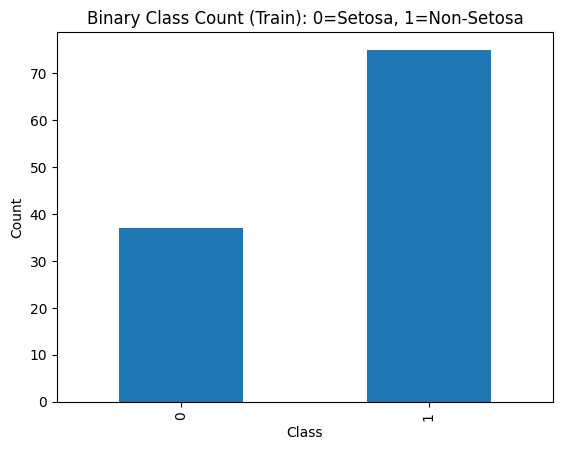

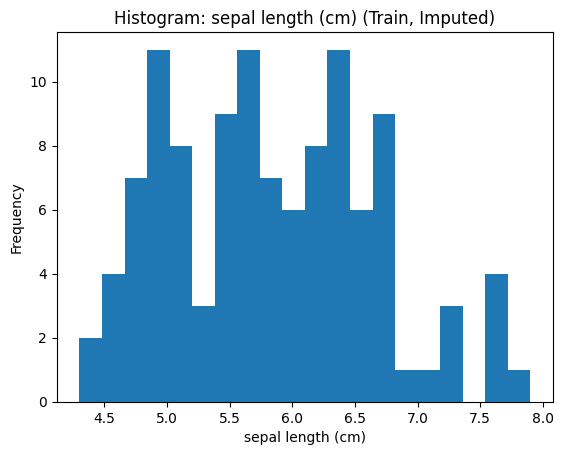

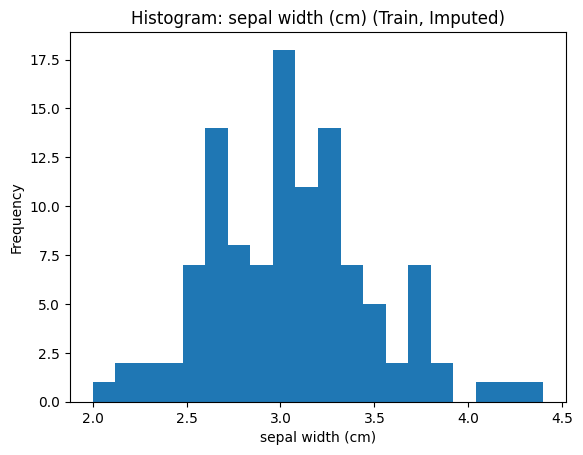

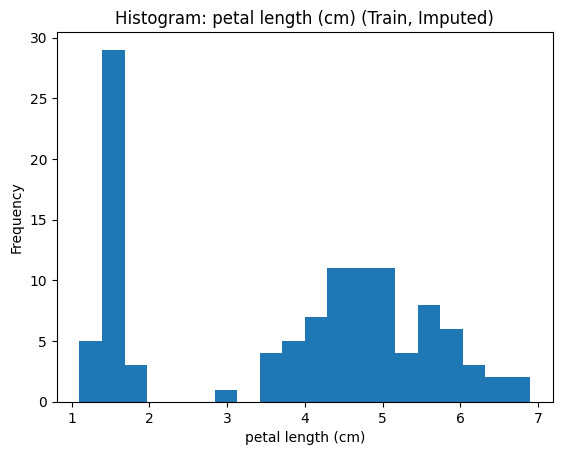

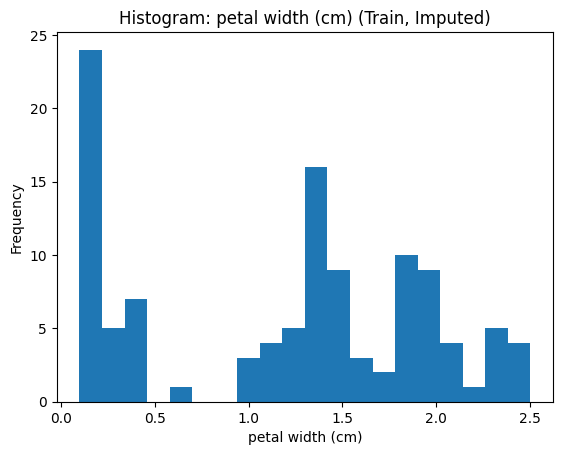

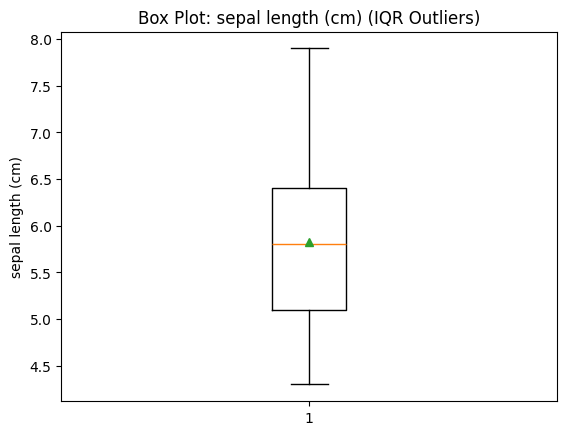

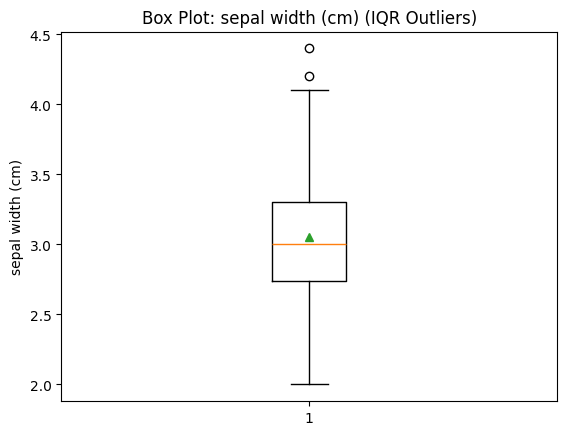

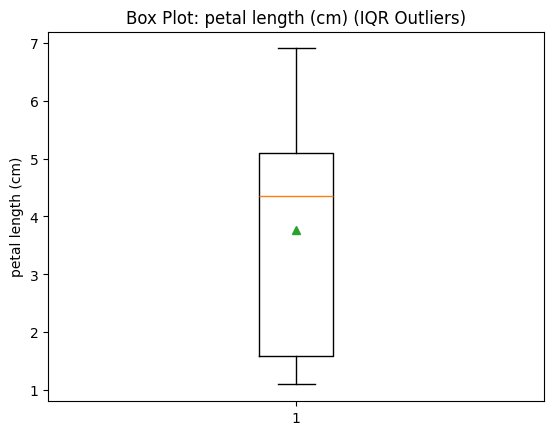

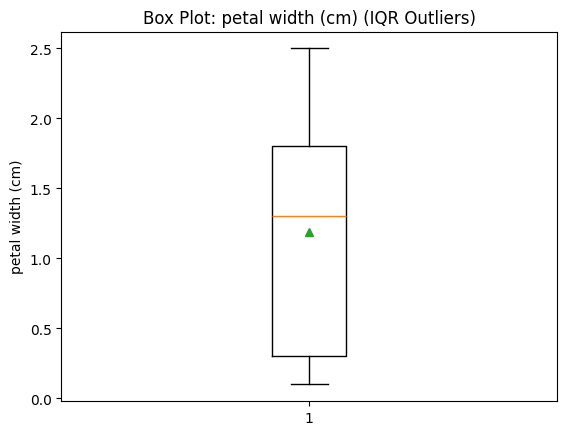


=== IQR / Outlier Summary (Train) ===
             Feature        Q1  Median   Q3       IQR  LowerBound  UpperBound  \
1   sepal width (cm)  2.736424    3.00  3.3  0.563576    1.891061    4.145363   
0  sepal length (cm)  5.100000    5.80  6.4  1.300000    3.150000    8.350000   
2  petal length (cm)  1.600000    4.35  5.1  3.500000   -3.650000   10.350000   
3   petal width (cm)  0.300000    1.30  1.8  1.500000   -1.950000    4.050000   

   OutlierCount  
1             2  
0             0  
2             0  
3             0  

Entropy (Imbalanced Train): 0.9153
Entropy (Pure all-0): -0.0  | (Pure all-1): -0.0

Class counts:
Imbalanced: [37 75]
UnderSample: [37 37]
OverSample : [75 75]
SMOTE      : [75 75]

Entropy:
Imbalanced: 0.9153
UnderSample: 1.0
OverSample : 1.0
SMOTE      : 1.0

=== ID3-like Decision Tree (Entropy/InfoGain) ===
Confusion Matrix:
 [[13  0]
 [ 0 25]]
TN: 13
FP: 0
FN: 0
TP: 25
Accuracy: 1.0000
Precision: 1.0000
Recall/Sensitivity: 1.0000
Specificity: 1.0000
F1: 1

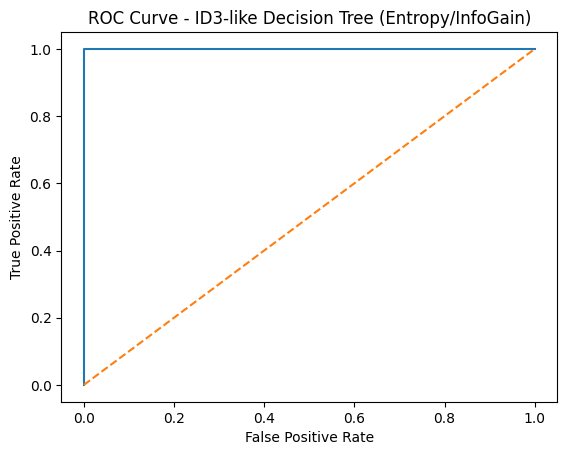


--- Decision Tree Rules (export_text) ---

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- class: 1


=== Bayesian Classifier (GaussianNB) ===
Confusion Matrix:
 [[13  0]
 [ 0 25]]
TN: 13
FP: 0
FN: 0
TP: 25
Accuracy: 1.0000
Precision: 1.0000
Recall/Sensitivity: 1.0000
Specificity: 1.0000
F1: 1.0000
ROC_AUC: 1.0000


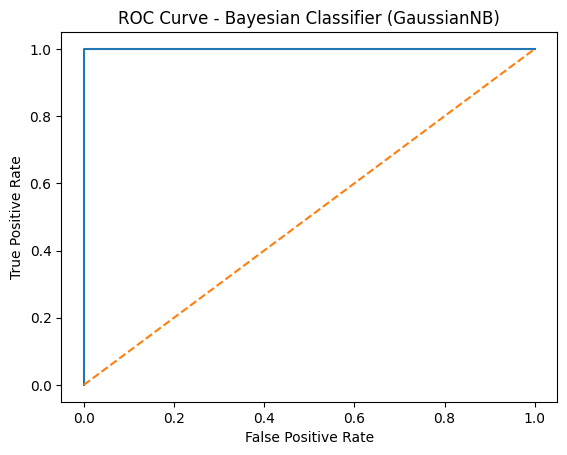


Best MLP params: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (8,), 'mlp__learning_rate_init': 0.001}

=== MLP Backprop NN (Tuned) ===
Confusion Matrix:
 [[13  0]
 [ 0 25]]
TN: 13
FP: 0
FN: 0
TP: 25
Accuracy: 1.0000
Precision: 1.0000
Recall/Sensitivity: 1.0000
Specificity: 1.0000
F1: 1.0000
ROC_AUC: 1.0000


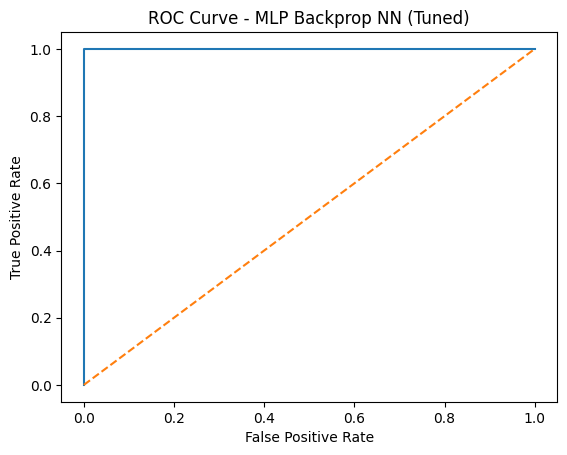


MLP Train Acc: 1.0 | Test Acc: 1.0
Bias/Variance Diagnosis: Low Bias & Low Variance (good generalization)

=== Multivariate Linear Regression (Predict Petal Length) ===
RMSE: 0.3291
R2  : 0.9659


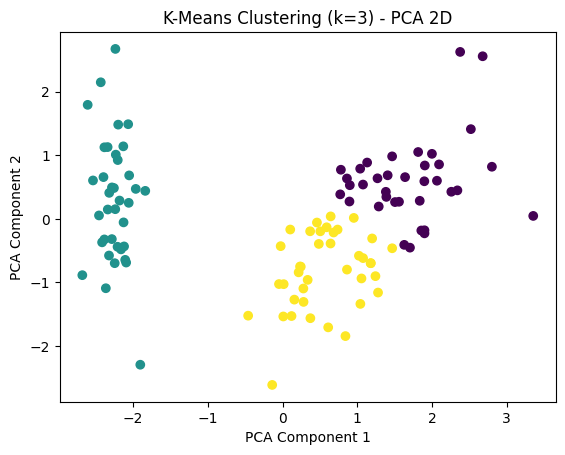

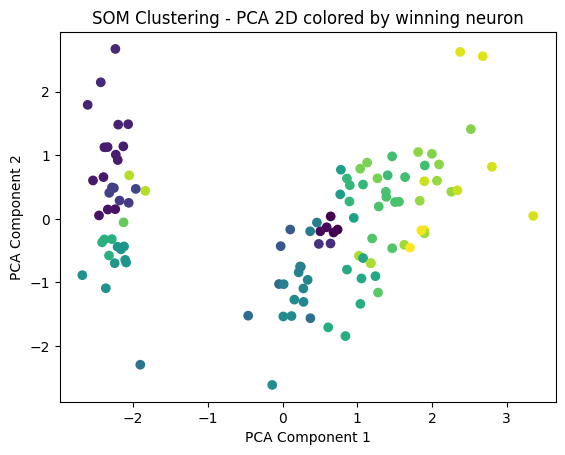

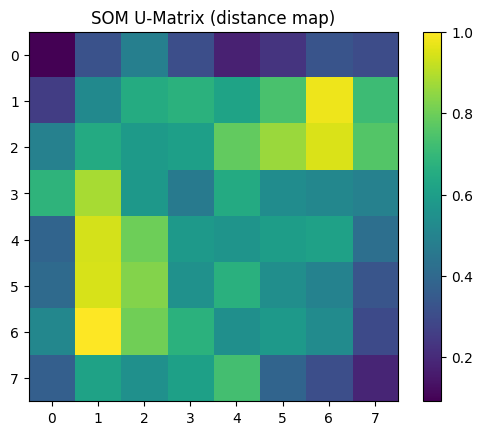

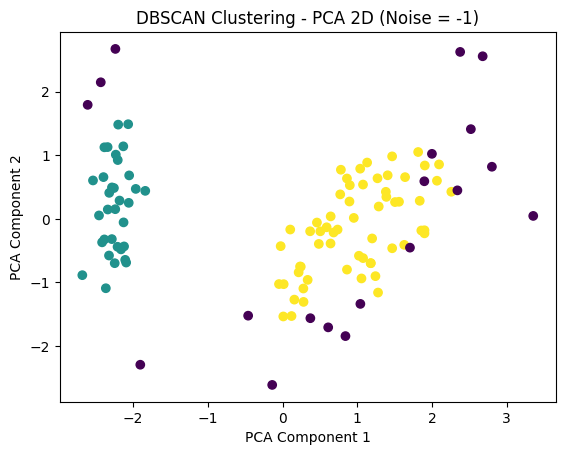

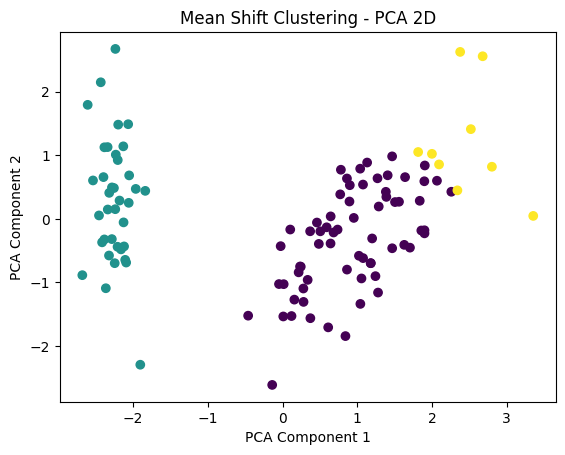


=== Silhouette Scores (Train, Unsupervised) ===
KMeans(k=3): Silhouette Score = 0.4703
SOM(grid labels): Silhouette Score = 0.2344
DBSCAN: Silhouette Score = 0.6513
MeanShift: Silhouette Score = 0.4565

DONE ✅  Capstone 3 (Iris) Modules 1–8 executed with graphs.


In [2]:
# ============================================================
# CAPSTONE PROJECT 3: IRIS DATASET (Modules 1–8)
# Single end-to-end script (run top-to-bottom in Colab/Jupyter)
# Includes: Imputation, Symmetry, Transformations, Visuals, Balancing,
# Supervised Models (ID3, NB, MLP tuned, Linear Regression),
# Unsupervised Models (KMeans, SOM, DBSCAN, MeanShift) + GRAPHS,
# Metrics (CM-based + ROC), Silhouette for clustering
# ============================================================

# -------------------------
# 0) Install (if needed)
# -------------------------
# In Colab, uncomment:
!pip -q install scikit-learn imbalanced-learn minisom scipy


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import skew

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, silhouette_score, mean_squared_error, r2_score
)

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, PowerTransformer, label_binarize
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression

from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from minisom import MiniSom

# -------------------------
# 1) Load Iris (REAL)
# -------------------------
iris = load_iris(as_frame=True)
df = iris.frame.copy()  # includes target
df.rename(columns={"target": "Species"}, inplace=True)

# Map to readable names
species_names = iris.target_names
df["SpeciesName"] = df["Species"].map({i: name for i, name in enumerate(species_names)})

feature_cols = iris.feature_names  # 4 features
print("Shape:", df.shape)
print(df.head())

# ----------------------------------------------------------
# Module 1: Data Cleaning + Ensure missing values exist
# ----------------------------------------------------------
# Iris normally has NO missing values -> we introduce missingness artificially (realistic for cleaning practice)
# We'll set ~7% missing per feature (random, reproducible)
rng = np.random.default_rng(42)
df_missing = df.copy()

missing_rate = 0.07
for c in feature_cols:
    mask = rng.random(len(df_missing)) < missing_rate
    df_missing.loc[mask, c] = np.nan

print("\nMissing values count AFTER injecting missingness:")
print(df_missing[feature_cols].isna().sum())

X = df_missing[feature_cols].copy()
y_multi = df_missing["Species"].astype(int)  # 0/1/2

# For classification metrics (Sensitivity/Specificity/ROC) we will also build a BINARY target:
# Setosa (0) vs Non-Setosa (1)
y_bin = (y_multi != 0).astype(int)

# Split
X_train, X_test, y_train_bin, y_test_bin = train_test_split(
    X, y_bin, test_size=0.25, random_state=42, stratify=y_bin
)

# --- 1A) SimpleImputer (median)
simple_imputer = SimpleImputer(strategy="median")
Xtr_simple = pd.DataFrame(simple_imputer.fit_transform(X_train), columns=feature_cols, index=X_train.index)
Xte_simple = pd.DataFrame(simple_imputer.transform(X_test), columns=feature_cols, index=X_test.index)

# --- 1B) KNNImputer
knn_imputer = KNNImputer(n_neighbors=5, weights="distance")
Xtr_knn = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=feature_cols, index=X_train.index)
Xte_knn = pd.DataFrame(knn_imputer.transform(X_test), columns=feature_cols, index=X_test.index)

# --- 1C) IterativeImputer
iter_imputer = IterativeImputer(random_state=42, max_iter=20)
Xtr_iter = pd.DataFrame(iter_imputer.fit_transform(X_train), columns=feature_cols, index=X_train.index)
Xte_iter = pd.DataFrame(iter_imputer.transform(X_test), columns=feature_cols, index=X_test.index)

print("\nMissing after imputation (IterativeImputer train):")
print(Xtr_iter.isna().sum())

# Choose one imputed dataset for remaining modules
Xtr = Xtr_iter.copy()
Xte = Xte_iter.copy()

# ----------------------------------------------------------
# Module 2: Symmetry check (Mean, Median, Skewness)
# ----------------------------------------------------------
def classify_skew(sk):
    if abs(sk) < 0.5:
        return "Symmetric"
    elif sk >= 0.5:
        return "Right-Skewed"
    else:
        return "Left-Skewed"

sym_rows = []
for c in feature_cols:
    mean_v = Xtr[c].mean()
    med_v  = Xtr[c].median()
    sk     = skew(Xtr[c], bias=False)
    sym_rows.append([c, mean_v, med_v, sk, classify_skew(sk)])

symmetry_df = pd.DataFrame(sym_rows, columns=["Feature","Mean","Median","Skewness","Class"])
print("\n=== Symmetry Report (Train) ===")
print(symmetry_df.sort_values("Skewness"))

# ----------------------------------------------------------
# Module 3: Preprocessing + Transformations to fix skewness
# ----------------------------------------------------------
# Scalers
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "MaxAbsScaler": MaxAbsScaler()
}

print("\n=== Scaler Demo: mean/std after scaling (Train) ===")
for sname, scaler in scalers.items():
    X_scaled = pd.DataFrame(scaler.fit_transform(Xtr), columns=feature_cols, index=Xtr.index)
    print(f"\n{sname}:")
    print(X_scaled.agg(["mean","std"]).round(3))

# Skewness fixing via Yeo-Johnson on skewed features
skewed_features = symmetry_df.loc[symmetry_df["Skewness"].abs() >= 0.5, "Feature"].tolist()
print("\nSkewed features (|skew|>=0.5):", skewed_features)

Xtr_tf = Xtr.copy()
Xte_tf = Xte.copy()

if len(skewed_features) > 0:
    pt = PowerTransformer(method="yeo-johnson", standardize=False)
    Xtr_tf[skewed_features] = pt.fit_transform(Xtr[skewed_features])
    Xte_tf[skewed_features] = pt.transform(Xte[skewed_features])

# Skewness check after
after_rows = []
for c in feature_cols:
    sk_before = float(symmetry_df.loc[symmetry_df["Feature"] == c, "Skewness"].values[0])
    sk_after  = float(skew(Xtr_tf[c], bias=False))
    after_rows.append([c, sk_before, sk_after])

sk_fix_df = pd.DataFrame(after_rows, columns=["Feature","Skew_Before","Skew_After"]).sort_values("Skew_Before")
print("\n=== Skewness Before vs After (Yeo-Johnson on skewed) ===")
print(sk_fix_df)

# ----------------------------------------------------------
# Module 4: Univariate Visualization (Bar, Histogram, Box with IQR)
# ----------------------------------------------------------
# Bar plot: class distribution (binary)
plt.figure()
pd.Series(y_train_bin).value_counts().sort_index().plot(kind="bar")
plt.title("Binary Class Count (Train): 0=Setosa, 1=Non-Setosa")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Histograms
for c in feature_cols:
    plt.figure()
    plt.hist(Xtr[c], bins=20)
    plt.title(f"Histogram: {c} (Train, Imputed)")
    plt.xlabel(c)
    plt.ylabel("Frequency")
    plt.show()

# Box plots + IQR outliers
def iqr_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5*iqr
    high = q3 + 1.5*iqr
    outs = series[(series < low) | (series > high)]
    return q1, series.median(), q3, iqr, low, high, outs

out_summary = []
for c in feature_cols:
    q1, med, q3, iqr, low, high, outs = iqr_outliers(Xtr[c])
    out_summary.append([c, q1, med, q3, iqr, low, high, len(outs)])

    plt.figure()
    plt.boxplot(Xtr[c], vert=True, showmeans=True)
    plt.title(f"Box Plot: {c} (IQR Outliers)")
    plt.ylabel(c)
    plt.show()

out_df = pd.DataFrame(out_summary, columns=["Feature","Q1","Median","Q3","IQR","LowerBound","UpperBound","OutlierCount"])
print("\n=== IQR / Outlier Summary (Train) ===")
print(out_df.sort_values("OutlierCount", ascending=False))

# ----------------------------------------------------------
# Module 5: Balancing (Under, Over, SMOTE) + Entropy
# ----------------------------------------------------------
def entropy_of_labels(labels):
    labels = np.asarray(labels).astype(int)
    counts = np.bincount(labels)
    probs = counts[counts > 0] / counts.sum()
    return float(-(probs * np.log2(probs)).sum())

H_imbal = entropy_of_labels(y_train_bin)
H_pure0 = entropy_of_labels(np.zeros_like(y_train_bin))
H_pure1 = entropy_of_labels(np.ones_like(y_train_bin))
print("\nEntropy (Imbalanced Train):", round(H_imbal, 4))
print("Entropy (Pure all-0):", round(H_pure0, 4), " | (Pure all-1):", round(H_pure1, 4))

Xtr_base = Xtr_tf.copy()
ytr_base = pd.Series(y_train_bin, index=Xtr_base.index)

rus = RandomUnderSampler(random_state=42)
ros = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=42, k_neighbors=5)

X_rus, y_rus = rus.fit_resample(Xtr_base, ytr_base)
X_ros, y_ros = ros.fit_resample(Xtr_base, ytr_base)
X_smt, y_smt = smote.fit_resample(Xtr_base, ytr_base)

print("\nClass counts:")
print("Imbalanced:", np.bincount(ytr_base.values))
print("UnderSample:", np.bincount(y_rus.values))
print("OverSample :", np.bincount(y_ros.values))
print("SMOTE      :", np.bincount(y_smt.values))

print("\nEntropy:")
print("Imbalanced:", round(entropy_of_labels(ytr_base.values), 4))
print("UnderSample:", round(entropy_of_labels(y_rus.values), 4))
print("OverSample :", round(entropy_of_labels(y_ros.values), 4))
print("SMOTE      :", round(entropy_of_labels(y_smt.values), 4))

def bias_variance_label(train_acc, test_acc, gap_threshold=0.08, low_threshold=0.85):
    gap = train_acc - test_acc
    if train_acc < low_threshold and test_acc < low_threshold:
        return "High Bias (underfitting)"
    if gap > gap_threshold and train_acc >= low_threshold:
        return "High Variance (overfitting)"
    if train_acc >= low_threshold and test_acc >= low_threshold and gap <= gap_threshold:
        return "Low Bias & Low Variance (good generalization)"
    return "Mixed/Needs tuning"

# ----------------------------------------------------------
# Module 6: Supervised Models (Binary classification for CM-based metrics)
# ----------------------------------------------------------
def classification_report_from_cm(y_true, y_pred, y_prob=None, title=""):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy  = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) else 0.0
    f1 = (2*precision*recall)/(precision+recall) if (precision+recall) else 0.0

    out = {
        "TN": tn, "FP": fp, "FN": fn, "TP": tp,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall/Sensitivity": recall,
        "Specificity": specificity,
        "F1": f1
    }

    if y_prob is not None:
        out["ROC_AUC"] = roc_auc_score(y_true, y_prob)

    print(f"\n=== {title} ===")
    print("Confusion Matrix:\n", cm)
    for k, v in out.items():
        if k in ["TN","FP","FN","TP"]:
            print(f"{k}: {v}")
        else:
            print(f"{k}: {v:.4f}")

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1], linestyle="--")
        plt.title(f"ROC Curve - {title}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()

    return out

# Use (train/test) transformed features
X_train_model = Xtr_base.copy()
X_test_model  = Xte_tf.copy()

# a) ID3-like Decision Tree (Entropy / Information Gain) + rules
dt = DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=42)
dt.fit(X_train_model, y_train_bin)

y_pred_dt = dt.predict(X_test_model)
y_prob_dt = dt.predict_proba(X_test_model)[:, 1]
dt_metrics = classification_report_from_cm(y_test_bin, y_pred_dt, y_prob_dt, title="ID3-like Decision Tree (Entropy/InfoGain)")

rules = export_text(dt, feature_names=list(X_train_model.columns))
print("\n--- Decision Tree Rules (export_text) ---\n")
print(rules)

# b) Bayesian Classifier (GaussianNB)
nb_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("nb", GaussianNB())
])
nb_pipe.fit(X_train_model, y_train_bin)

y_pred_nb = nb_pipe.predict(X_test_model)
y_prob_nb = nb_pipe.predict_proba(X_test_model)[:, 1]
nb_metrics = classification_report_from_cm(y_test_bin, y_pred_nb, y_prob_nb, title="Bayesian Classifier (GaussianNB)")

# c) MLP Backprop NN + hyper-tuning
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(max_iter=3000, random_state=42))
])

param_grid = {
    "mlp__hidden_layer_sizes": [(8,), (16,), (32,), (32,16)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": [1e-4, 1e-3, 1e-2],
    "mlp__learning_rate_init": [1e-3, 5e-4],
}

gs = GridSearchCV(
    mlp_pipe, param_grid=param_grid,
    scoring="f1", cv=5, n_jobs=-1, verbose=0
)
gs.fit(X_train_model, y_train_bin)

print("\nBest MLP params:", gs.best_params_)
best_mlp = gs.best_estimator_

y_pred_mlp = best_mlp.predict(X_test_model)
y_prob_mlp = best_mlp.predict_proba(X_test_model)[:, 1]
mlp_metrics = classification_report_from_cm(y_test_bin, y_pred_mlp, y_prob_mlp, title="MLP Backprop NN (Tuned)")

train_acc_mlp = accuracy_score(y_train_bin, best_mlp.predict(X_train_model))
test_acc_mlp  = accuracy_score(y_test_bin, y_pred_mlp)
print("\nMLP Train Acc:", round(train_acc_mlp, 4), "| Test Acc:", round(test_acc_mlp, 4))
print("Bias/Variance Diagnosis:", bias_variance_label(train_acc_mlp, test_acc_mlp))

# d) Multivariate Linear Regression (prediction)
# Predict one feature using other features: predict "petal length (cm)" from the remaining 3 features
target_reg = feature_cols[2]  # petal length (cm)
Xreg_train = X_train_model.drop(columns=[target_reg])
yreg_train = X_train_model[target_reg]
Xreg_test  = X_test_model.drop(columns=[target_reg])
yreg_test  = X_test_model[target_reg]

reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])
reg_pipe.fit(Xreg_train, yreg_train)
yreg_pred = reg_pipe.predict(Xreg_test)

rmse = np.sqrt(mean_squared_error(yreg_test, yreg_pred))
r2   = r2_score(yreg_test, yreg_pred)
print("\n=== Multivariate Linear Regression (Predict Petal Length) ===")
print("RMSE:", round(rmse, 4))
print("R2  :", round(r2, 4))

# ----------------------------------------------------------
# Module 7: Unsupervised Learning + GRAPHS
# ----------------------------------------------------------
# Use scaled features for clustering
X_uns = StandardScaler().fit_transform(X_train_model)

# PCA 2D for plotting
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_uns)

def plot_clusters(title, labels):
    plt.figure()
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# a) K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
k_labels = kmeans.fit_predict(X_uns)
plot_clusters("K-Means Clustering (k=3) - PCA 2D", k_labels)

# b) SOM
som_x, som_y = 8, 8
som = MiniSom(som_x, som_y, X_uns.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)
som.random_weights_init(X_uns)
som.train_random(X_uns, num_iteration=2000)

winners = np.array([som.winner(x) for x in X_uns])
som_labels = winners[:, 0] * som_y + winners[:, 1]
plot_clusters("SOM Clustering - PCA 2D colored by winning neuron", som_labels)

# SOM U-Matrix (distance map)
umatrix = som.distance_map()
plt.figure()
plt.imshow(umatrix)
plt.title("SOM U-Matrix (distance map)")
plt.colorbar()
plt.show()

# c) DBSCAN
db = DBSCAN(eps=0.6, min_samples=5)
db_labels = db.fit_predict(X_uns)
plot_clusters("DBSCAN Clustering - PCA 2D (Noise = -1)", db_labels)

# d) Mean Shift
bw = estimate_bandwidth(X_uns, quantile=0.2, n_samples=min(500, X_uns.shape[0]))
bw = bw if (bw is not None and bw > 0) else 1.0
ms = MeanShift(bandwidth=bw, bin_seeding=True)
ms_labels = ms.fit_predict(X_uns)
plot_clusters("Mean Shift Clustering - PCA 2D", ms_labels)

# ----------------------------------------------------------
# Module 8: Performance Metrics
#   - Classification: Sensitivity, Specificity, Accuracy, Precision, Recall, F1, ROC already printed
#   - Clustering: Silhouette Score
# ----------------------------------------------------------
def safe_silhouette(X, labels, name):
    unique = set(labels)
    if len(unique) < 2:
        print(f"{name}: Silhouette not valid (only 1 cluster).")
        return None
    if unique == {-1}:
        print(f"{name}: Silhouette not valid (all noise).")
        return None
    if -1 in unique:
        mask = labels != -1
        if len(set(labels[mask])) < 2:
            print(f"{name}: Silhouette not valid (after removing noise, <2 clusters).")
            return None
        score = silhouette_score(X[mask], labels[mask])
    else:
        score = silhouette_score(X, labels)
    print(f"{name}: Silhouette Score = {score:.4f}")
    return score

print("\n=== Silhouette Scores (Train, Unsupervised) ===")
safe_silhouette(X_uns, k_labels, "KMeans(k=3)")
safe_silhouette(X_uns, som_labels, "SOM(grid labels)")
safe_silhouette(X_uns, db_labels, "DBSCAN")
safe_silhouette(X_uns, ms_labels, "MeanShift")

print("\nDONE ✅  Capstone 3 (Iris) Modules 1–8 executed with graphs.")
